<function matplotlib.pyplot.show(close=None, block=None)>

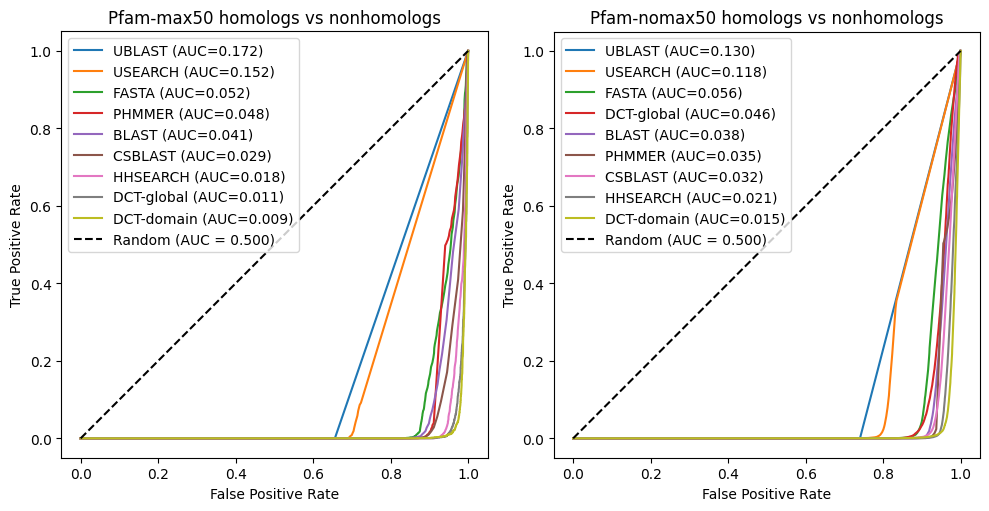

In [6]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from operator import itemgetter

benchlist = ["max50", "nomax50"]
labelfilelist = ["../pfam_data/pfam_max50.pair", "../pfam_data/pfam_nomax50.pair.found"]
dctsimlist = ["../pfam_data/pfam_max50-dctsim.txt", "../pfam_data/pfam_nomax50-dctsim.txt"]
resultslist = ["results/pfam_max50/", "results/pfam_nomax50"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for b in range(2):
    bench = benchlist[b]
    labelfile = labelfilelist[b]
    dctsim = dctsimlist[b]

    data = pd.read_csv(dctsim, sep=" ")
    label = pd.read_csv(labelfile, sep=" ")
    data['label'] = label['label']
    if data.shape[0] != label.shape[0]:
        print(f"Warning: the two inputs have different pairs: {data.shape[0]} vs {label.shape[0]}")
    hom = label.loc[data['label'] != 'nonhom']
    nonhom = data.loc[data['label'] == 'nonhom']
    pos_n = hom.shape[0]
    neg_n = nonhom.shape[0]
    
    #print(f"total positive cases {pos_n} negative cases {neg_n}")
    
    y = [1] * pos_n
    y.extend([0] * neg_n)
    rocs = []
    pred_l = data['sim-domain']
    fpr_l, tpr_l, thresholds_l = metrics.roc_curve(y, pred_l, pos_label=1)
    auc_l = metrics.auc(fpr_l, tpr_l)
    #print(f"AUC using DCT-domain {auc_l:.3f}")
    rocs.append(["DCT-domain", fpr_l, tpr_l, auc_l])

    pred_g = data['sim-global']
    fpr_g, tpr_g, thresholds_g = metrics.roc_curve(y, pred_g, pos_label=1)
    auc_g = metrics.auc(fpr_g, tpr_g)
    #print(f"AUC using DCT-global {auc_g:.3f}")
    rocs.append(["DCT-global", fpr_g, tpr_g, auc_g])
    
    import sys
    approaches = ["csblast", "phmmer", "blast", "fasta", "usearch", "ublast", "hhsearch"]
    for ap in approaches:
        file = f"{resultslist[b]}/{ap}_results.csv"
        df = pd.read_csv(file, sep=",")
        #print(f"{ap} {file} {df.shape}")
        df.columns = ['label', 'pred']
        sel = label.loc[df['label'] == 1]
        #print(f"positive {sel.shape[0]}")

        fpr, tpr, thresholds = metrics.roc_curve(df['label'], df['pred'], pos_label=1)
        auc = metrics.auc(fpr, tpr)
        rocs.append([ap.upper(), fpr, tpr, auc])

    roc_sorted = sorted(rocs, key=itemgetter(3), reverse=True)
    for (ap, fpr, tpr, auc) in roc_sorted:
        axes[b].plot(fpr, tpr, label=f"{ap} (AUC={auc:.3f})")
    
    axes[b].plot([0,1], [0,1], "k--", label="Random (AUC = 0.500)")
    axes[b].axis("square")
    axes[b].set_xlabel("False Positive Rate")
    axes[b].set_ylabel("True Positive Rate")
    axes[b].set_title(f"Pfam-{bench} homologs vs nonhomologs")
    axes[b].legend()

fig.tight_layout()
plt.show
    